In [43]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
# from __future__ import print_function
import keras
from keras.preprocessing.image import ImageDataGenerator, load_img
from keras import models
from keras import layers
from keras import optimizers

import glob, os
from skimage import io, color, exposure, transform
from skimage.color import rgb2gray

from keras.optimizers import SGD
from keras.callbacks import LearningRateScheduler, ModelCheckpoint
from keras.layers import Input, Flatten, Dense

In [32]:
# train_dir = '/home/atif/machine_learning_stuff/ml_image/copy_image/train'
# validation_dir = '/home/atif/machine_learning_stuff/ml_image/copy_image/validation'

train_dir = '/home/atif/machine_learning_stuff/ml_image/train_image_AI'
validation_dir = '/home/atif/machine_learning_stuff/ml_image/validation_image_AI'
path_pre_trained_model = '/home/atif/machine_learning_stuff/model_file_keras/'
IMG_SIZE = 48
IMG_depth = 3 # for RGB 3, for B&W it will be 1
NUM_CLASSES = 16

# All layers are freezed. Same as pre trained weights

In [41]:
from keras.applications import VGG16

# Download the VGG 16 model . Check here https://github.com/keras-team/keras/issues/5257#issuecomment-314628173 .
# with TF backend maybe not possible to use VGG 16 with channel first
# vgg_conv = VGG16(weights='imagenet', include_top=False, input_shape=(IMG_depth,IMG_SIZE,IMG_SIZE))

58892288/58889256 [==============================] - 6s 0us/step


In [7]:
#Load the VGG model
loaded_vgg = VGG16(weights=path_pre_trained_model+'vgg_top_48_shape/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5', include_top=False, input_shape=(IMG_SIZE,IMG_SIZE, 3))

In [46]:
# Freeze all the layers
for layer in loaded_vgg.layers[:-4]:
    layer.trainable = False
    
# If I write here layer.trainable = True then layer from top will be true. WHY?? because the indexing of the array is taking this decision. fro  top
# to before the last 4 layer I have told to be False rest are will be true

In [47]:
# Check the trainable status of the individual layers
for layer in loaded_vgg.layers:
    print(layer, layer.trainable)

<keras.engine.topology.InputLayer object at 0x7f17b64fb828> False
<keras.layers.convolutional.Conv2D object at 0x7f17b64fb978> False
<keras.layers.convolutional.Conv2D object at 0x7f17b64fb7b8> False
<keras.layers.pooling.MaxPooling2D object at 0x7f17b64fb9b0> False
<keras.layers.convolutional.Conv2D object at 0x7f17b6a75198> False
<keras.layers.convolutional.Conv2D object at 0x7f17b6a75b38> False
<keras.layers.pooling.MaxPooling2D object at 0x7f17b68c6fd0> False
<keras.layers.convolutional.Conv2D object at 0x7f17b6b6f7b8> False
<keras.layers.convolutional.Conv2D object at 0x7f17b6b36cf8> False
<keras.layers.convolutional.Conv2D object at 0x7f17b6aad780> False
<keras.layers.pooling.MaxPooling2D object at 0x7f17b6ad8f98> False
<keras.layers.convolutional.Conv2D object at 0x7f17b69b7860> False
<keras.layers.convolutional.Conv2D object at 0x7f17b68f86a0> False
<keras.layers.convolutional.Conv2D object at 0x7f17b68257f0> False
<keras.layers.pooling.MaxPooling2D object at 0x7f17b67dbf28> Fa

In [48]:
# Create the model
model = models.Sequential()

# Add the vgg convolutional base model
model.add(loaded_vgg)

# Add new layers
model.add(layers.Flatten())
model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dense(4096, activation='relu'))
model.add(layers.Dense(4096, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(NUM_CLASS, activation='softmax'))

# Show a summary of the model. Check the number of trainable parameters
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 1, 1, 512)         14714688  
_________________________________________________________________
flatten_2 (Flatten)          (None, 512)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 1024)              525312    
_________________________________________________________________
dense_6 (Dense)              (None, 4096)              4198400   
_________________________________________________________________
dense_7 (Dense)              (None, 4096)              16781312  
_________________________________________________________________
dropout_2 (Dropout)          (None, 4096)              0         
_________________________________________________________________
dense_8 (Dense)              (None, 16)                65552     
Total para

In [49]:
def preprocess_img(img):
    # Histogram normalization in y
    hsv = color.rgb2hsv(img)
    hsv[:,:,2] = exposure.equalize_hist(hsv[:,:,2])
    img = color.hsv2rgb(hsv)

    # central scrop
    min_side = min(img.shape[:-1])
    centre = img.shape[0]//2, img.shape[1]//2
    img = img[centre[0]-min_side//2:centre[0]+min_side//2,centre[1]-min_side//2:centre[1]+min_side//2,:]
#    img = rgb2gray(img)

    # rescale to standard size
    img = transform.resize(img, (IMG_SIZE, IMG_SIZE))

    # roll color axis to axis 0
#     img = np.rollaxis(img,-1) # this lin is doing the channel fisrt operation

    return img

def get_class(img_path):
    return int(img_path.split('/')[-2])
#     return str(img_path.split('/')[-2]) # returning the folder name. If use -1 that means image name. consider the img_path.

In [50]:
imgs = []
labels = []
root_dir = '/home/atif/machine_learning_stuff/ml_image/train_image_AI/'
#path='/home/atif/training_by_several_learning_process/flower_photos/00000/'

#all_img_paths = glob.glob(path+ '5547758_eea9edfd54_n_000.jpg')

all_img_paths = glob.glob(os.path.join(root_dir, '*/*.png')) #I have done the training with .png format image. If another type of image will come 
                                                                                    #them .png will be changed by that extension
np.random.shuffle(all_img_paths)
for img_path in all_img_paths:
    try:
        img = preprocess_img(io.imread(img_path))
        label = get_class(img_path)
        imgs.append(img)
        labels.append(label)

        if len(imgs)%1200 == 0: print("Processed {}/{}".format(len(imgs), len(all_img_paths)))
            #print("get it 2")
    except (IOError, OSError):
        print('missed', img_path)
        pass

Processed 1200/57600
Processed 2400/57600
Processed 3600/57600
Processed 4800/57600
Processed 6000/57600
Processed 7200/57600
Processed 8400/57600
Processed 9600/57600
Processed 10800/57600
Processed 12000/57600
Processed 13200/57600
Processed 14400/57600
Processed 15600/57600
Processed 16800/57600
Processed 18000/57600
Processed 19200/57600
Processed 20400/57600
Processed 21600/57600
Processed 22800/57600
Processed 24000/57600
Processed 25200/57600
Processed 26400/57600
Processed 27600/57600
Processed 28800/57600
Processed 30000/57600
Processed 31200/57600
Processed 32400/57600
Processed 33600/57600
Processed 34800/57600
Processed 36000/57600
Processed 37200/57600
Processed 38400/57600
Processed 39600/57600
Processed 40800/57600
Processed 42000/57600
Processed 43200/57600
Processed 44400/57600
Processed 45600/57600
Processed 46800/57600
Processed 48000/57600
Processed 49200/57600
Processed 50400/57600
Processed 51600/57600
Processed 52800/57600
Processed 54000/57600
Processed 55200/57

In [53]:
X = np.array(imgs, dtype='float32') #Keeping the image as an array
X = X.reshape(len(imgs),IMG_SIZE,IMG_SIZE,IMG_depth) # write (IMG_SIZE,IMG_SIZE,1 if you want channel last; 1= grayscale;3=RGB)
# Y = np.eye(NUM_CLASSES, dtype='uint8')[labels]
Y = keras.utils.to_categorical(labels, NUM_CLASSES)

print('X shape: ', X.shape,' type: ',type(X))
print('Y shape: ', Y.shape,' type: ',type(Y))

X shape:  (57600, 48, 48, 3)  type:  <class 'numpy.ndarray'>
Y shape:  (57600, 16)  type:  <class 'numpy.ndarray'>


In [54]:
lr = 0.01
sgd = SGD(lr=lr, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy',
          optimizer=sgd,
          metrics=['accuracy'])

In [55]:
path = '/home/atif/machine_learning_stuff/model_file_keras/'

In [56]:
import datetime
current_time = datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")
print("current time:", current_time)

current time: 2019-09-20 00:57:57


In [57]:
def lr_schedule(epoch):
    return lr * (0.1 ** int(epoch / 10))

batch_size = 32
epochs = 2
do_train_model=model.fit(X, Y,
          batch_size=batch_size,
          epochs=epochs,
          validation_split=0.2,verbose=2,
          #np.resize(img, (-1, <image shape>)
          callbacks=[LearningRateScheduler(lr_schedule)])
# ,ModelCheckpoint(path+str(current_time)+'_new_model_'+str(epochs)+'.h5', save_best_only=True)])

Train on 46080 samples, validate on 11520 samples
Epoch 1/2
 - 52s - loss: 0.1983 - acc: 0.9382 - val_loss: 0.0162 - val_acc: 0.9941
Epoch 2/2
 - 51s - loss: 0.0135 - acc: 0.9961 - val_loss: 9.1883e-04 - val_acc: 0.9997


In [59]:
model.save(path+str(current_time)+'_vgg16_epoch_'+str(epochs)+'.h5')

# Training. No image augmentation
# Image processing followed here different approach

In [5]:
epoch = 2
saved_model_path = '/home/atif/machine_learning_stuff/unreal_cv_image/unreal_cv_image_manipulation/classification_UE4_image/trained_model/'

In [7]:
image_size = IMG_SIZE

Found 57600 images belonging to 16 classes.
Found 48 images belonging to 16 classes.
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Epoch 1/2
576/576 [==============================] - 260s 452ms/step - loss: 0.2034 - acc: 0.9463 - val_loss: 5.8724e-04 - val_acc: 1.0000
Epoch 2/2
576/576 [==============================] - 258s 447ms/step - loss: 0.0051 - acc: 0.9988 - val_loss: 5.1559e-06 - val_acc: 1.0000


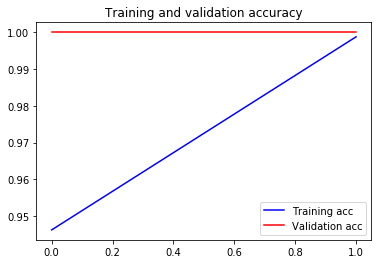

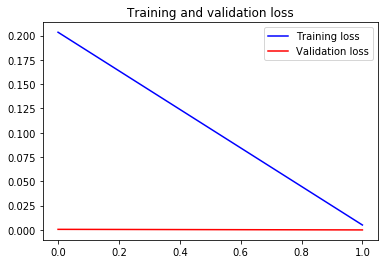

In [8]:
# No Data augmentation 
train_datagen = ImageDataGenerator(rescale=1./255)
validation_datagen = ImageDataGenerator(rescale=1./255)

# Change the batchsize according to your system RAM
train_batchsize = 100
val_batchsize = 10

# Data Generator for Training data
train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(image_size, image_size),
        batch_size=train_batchsize,
        class_mode='categorical')

# Data Generator for Validation data
validation_generator = validation_datagen.flow_from_directory(
        validation_dir,
        target_size=(image_size, image_size),
        batch_size=val_batchsize,
        class_mode='categorical',
        shuffle=False)

# Compile the model
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])

# Train the Model
history = model.fit_generator(
      train_generator,
      steps_per_epoch=train_generator.samples/train_generator.batch_size ,
      epochs=epoch,
      validation_data=validation_generator,
      validation_steps=validation_generator.samples/validation_generator.batch_size,
      verbose=1)

# Save the Model
model.save(saved_model_path+'all_freezed_old_1.h5')

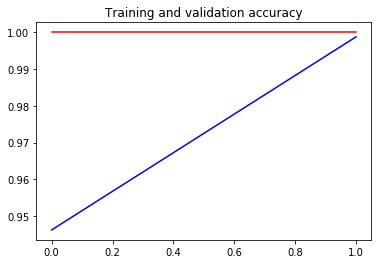

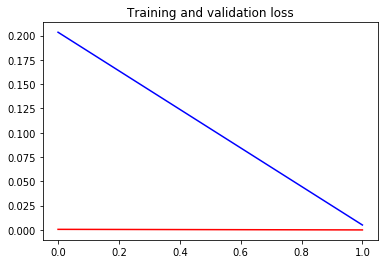

In [19]:
# Plot the accuracy and loss curves
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.savefig(saved_model_path+'vgg_16_img_aug_accuracy.jpg')
# plt.legend()

plt.figure()

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.savefig(saved_model_path+'vgg_16_img_aug_loss.jpg')
# plt.legend()

plt.show()

In [60]:
from keras.models import load_model
# model = load_model('/home/atif/machine_learning_stuff/model_file_keras/general_2_sep_ep_30_epoch.h5')
model = load_model(path+'2019-09-20 00:57:57_vgg16_epoch_2.h5')

In [61]:
import pandas as pd
test = pd.read_csv('/home/atif/machine_learning_stuff/ml_image/test_image_keras_IAI.csv',sep=';')
# test_image_path =  '/home/atif/machine_learning_stuff/ml_image/test_image_crop/'

X_test = []
y_test = []
i = 0
for file_name, class_id  in zip(list(test['Filename']), list(test['ClassId'])):
    print('filename: ',file_name,'\t classId: ',class_id)
    #print('classId: ',class_id)
    img_path = os.path.join('/home/atif/machine_learning_stuff/ml_image/test_image_26_aug/',file_name)
#     img_path = glob.glob(os.path.join(test_image_path, '*/*.jpg'))
    X_test.append(preprocess_img(io.imread(img_path)))
    y_test.append(class_id)
    
X_test = np.array(X_test)
y_test = np.array(y_test)

filename:  denkmit_edelstahk_reiniger (1).jpg 	 classId:  5
filename:  denkmit_edelstahk_reiniger (2).jpg 	 classId:  5
filename:  denkmit_edelstahk_reiniger (3).jpg 	 classId:  5
filename:  denkmit_edelstahk_reiniger (4).jpg 	 classId:  5
filename:  denkmit_edelstahk_reiniger (5).jpg 	 classId:  5
filename:  denkmit_edelstahk_reiniger (6).jpg 	 classId:  5
filename:  denkmit_edelstahk_reiniger (7).jpg 	 classId:  5
filename:  denkmit_Entkalker (1).jpg 	 classId:  7
filename:  denkmit_Entkalker (2).jpg 	 classId:  7
filename:  denkmit_Entkalker (3).jpg 	 classId:  7
filename:  denkmit_Entkalker (4).jpg 	 classId:  7
filename:  denkmit_Entkalker (5).jpg 	 classId:  7
filename:  denkmit_Entkalker (6).jpg 	 classId:  7
filename:  denkmit_geschirrreiniger_REVOLUTION (1).jpg 	 classId:  10
filename:  denkmit_geschirrreiniger_REVOLUTION (2).jpg 	 classId:  10
filename:  denkmit_geschirrreiniger_REVOLUTION (3).jpg 	 classId:  10
filename:  denkmit_geschirrreiniger_REVOLUTION (4).jpg 	 classId

In [62]:
X_test.shape

(89, 48, 48, 3)

In [63]:
y_pred = model.predict_classes(X_test)
acc = np.sum(y_pred==y_test)/np.size(y_pred)
print("Test accuracy = {}".format(acc))

Test accuracy = 0.6853932584269663


In [42]:
import glob

test_image_path = r'/home/atif/machine_learning_stuff/ml_image/test_image_26_aug/'

my_name = ['SM_CalgonitFinish_2','SM_CalgonitFinishKlarspueler_5','SM_CalgonitFinishMaschinenpfleger_8','SM_CalgonitFinishSpezialSalz_11',
           'SM_CalgonitFinishVorratspack_14','SM_DenkMitEdelstahlreiniger_17','SM_DenkMitEdelstahlReinigerSpray_20','SM_DenkMitEntkalker_23',
           'SM_DenkMitGeschirrReiniger_26','SM_DenkMitGeschirrReinigerClassic_29','SM_DenkMitGeschirrReinigerEvo_32','SM_DenkMitGeschirrReinigerNature_35',
           'SM_DenkMitHygieneAllzweckreiniger_38','SM_DenkMitMaschinenpfleger_41','SM_DenkMitSpezialsalz_44','SM_SomatClassic_53']

img_path = glob.glob(test_image_path+ '/*.jpg')
for image in img_path:
    X_test=[]
    X_test.append(preprocess_img(io.imread(image)))
    X_test = np.array(X_test)
#     plt.imshow(X_test)
    X_test = X_test.reshape(len(X_test),IMG_SIZE,IMG_SIZE,3)
    
    print('image name is: ',image)
    predicted_class = model.predict_classes(X_test)
    print("predicted class: ",predicted_class)
#     print('type-of predicted calss: ', type(predicted_class))
    print('class name is: ',my_name[predicted_class[0]])
    
#     probability = model.predict_proba(X_test)
#     print("probability: ",probability)
    print('\n')

image name is:  /home/atif/machine_learning_stuff/ml_image/test_image_26_aug/denkmit_hygiene_Allzweck_reiniger (4).jpg
predicted class:  [4]
class name is:  SM_CalgonitFinishVorratspack_14


image name is:  /home/atif/machine_learning_stuff/ml_image/test_image_26_aug/denkmit_edelstahk_reiniger (2).jpg
predicted class:  [10]
class name is:  SM_DenkMitGeschirrReinigerEvo_32


image name is:  /home/atif/machine_learning_stuff/ml_image/test_image_26_aug/calgonit_finish_speizalsalz (3).jpg
predicted class:  [9]
class name is:  SM_DenkMitGeschirrReinigerClassic_29


image name is:  /home/atif/machine_learning_stuff/ml_image/test_image_26_aug/denkmit_edelstahk_reiniger (5).jpg
predicted class:  [10]
class name is:  SM_DenkMitGeschirrReinigerEvo_32


image name is:  /home/atif/machine_learning_stuff/ml_image/test_image_26_aug/denkmit_edelstahk_reiniger (3).jpg
predicted class:  [10]
class name is:  SM_DenkMitGeschirrReinigerEvo_32


image name is:  /home/atif/machine_learning_stuff/ml_image/te

image name is:  /home/atif/machine_learning_stuff/ml_image/test_image_26_aug/denkmit_spezalsalz (3).jpg
predicted class:  [10]
class name is:  SM_DenkMitGeschirrReinigerEvo_32


image name is:  /home/atif/machine_learning_stuff/ml_image/test_image_26_aug/calgonit_maschine_pfleger (2).jpg
predicted class:  [10]
class name is:  SM_DenkMitGeschirrReinigerEvo_32


image name is:  /home/atif/machine_learning_stuff/ml_image/test_image_26_aug/denkmit_spezalsalz (1).jpg
predicted class:  [10]
class name is:  SM_DenkMitGeschirrReinigerEvo_32


image name is:  /home/atif/machine_learning_stuff/ml_image/test_image_26_aug/denkmit_spezalsalz (8).jpg
predicted class:  [10]
class name is:  SM_DenkMitGeschirrReinigerEvo_32


image name is:  /home/atif/machine_learning_stuff/ml_image/test_image_26_aug/denkmit_Entkalker (6).jpg
predicted class:  [9]
class name is:  SM_DenkMitGeschirrReinigerClassic_29


image name is:  /home/atif/machine_learning_stuff/ml_image/test_image_26_aug/denkmit_geschirr_reinige

# confusion matrix

In [43]:
from sklearn.metrics import confusion_matrix
results = confusion_matrix(y_test, y_pred)
print(results)
print(type(results))
print(results.shape)

[[5 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 6 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 4 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 4 2 0 0 0 0 0]
 [2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [2 0 0 0 0 0 0 0 0 0 5 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0]
 [0 0 0 0 0 0 0 0 0 4 2 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 5 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 5 0 0 0 0 1]
 [0 0 4 0 0 0 0 0 0 0 2 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 5 0 0 0 0 0]
 [0 0 0 0 5 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 2 4 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1 8 0 0 0 0 0]
 [0 0 0 0 0 0 0 8 0 0 0 0 0 0 0 0]]
<class 'numpy.ndarray'>
(16, 16)


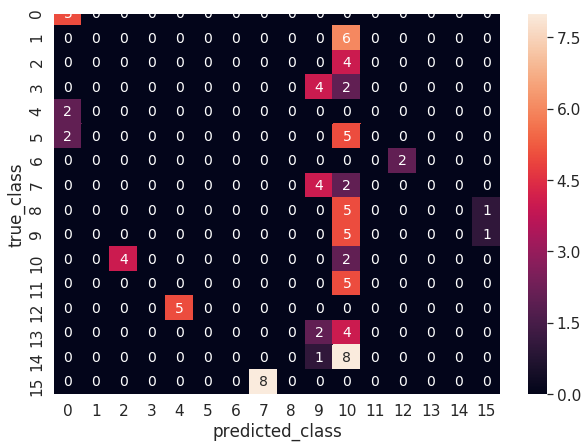

In [46]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

df_cm = pd.DataFrame(results, range(16),
                  range(16))
plt.figure(figsize = (10,7))
plt.tight_layout()
sn.set(font_scale=1.4)#for label size

ax = sn.heatmap(df_cm, annot=True,annot_kws={"size": 14},xticklabels=True, yticklabels=True)# font size
ax.set(xlabel='predicted_class', ylabel='true_class')
ax.set_ylim(16)
figure = ax.get_figure()    
# figure.savefig('2_sep_ax_conf.png', dpi=400)


In [26]:
# Create a generator for prediction
validation_generator = validation_datagen.flow_from_directory(
        validation_dir,
        target_size=(image_size, image_size),
        batch_size=val_batchsize,
        class_mode='categorical',
        shuffle=False)

# Get the filenames from the generator
fnames = validation_generator.filenames

# Get the ground truth from generator
ground_truth = validation_generator.classes

# Get the label to class mapping from the generator
label2index = validation_generator.class_indices

# Getting the mapping from class index to class label
idx2label = dict((v,k) for k,v in label2index.items())

# Get the predictions from the model using the generator
predictions = model.predict_generator(validation_generator, steps=validation_generator.samples/validation_generator.batch_size,verbose=1)
predicted_classes = np.argmax(predictions,axis=1)

errors = np.where(predicted_classes != ground_truth)[0]
print("No of errors = {}/{}".format(len(errors),validation_generator.samples))

# Show the errors
for i in range(len(errors)):
    pred_class = np.argmax(predictions[errors[i]])
    pred_label = idx2label[pred_class]
    
    title = 'Original label:{}, Prediction :{}, confidence : {:.3f}'.format(
        fnames[errors[i]].split('/')[0],
        pred_label,
        predictions[errors[i]][pred_class])
    
    original = load_img('{}/{}'.format(validation_dir,fnames[errors[i]]))
    plt.figure(figsize=[7,7])
    plt.axis('off')
    plt.title(title)
    plt.imshow(original)
    plt.show()

Found 48 images belonging to 16 classes.
5/4 [===============================] - 0s 82ms/step
No of errors = 0/48
